In [3]:
import pandas as pd
import plotly.graph_objects as go
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance
import cufflinks as cf
import talib
import pandas_ta
from tapy import Indicators
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

In [4]:
def get_his_data_filename(pair, granularity):
    return f"his_data/{pair}_{granularity}.csv"


In [5]:
def is_trade_MA(row):
    if row.DIFF >= 0 and row.DIFF_PREV < 0:
        return 1
    if row.DIFF <= 0 and row.DIFF_PREV > 0:
        return -1
    return 0

def confrontorisultati_MA(MA_long,MA_short,df):
    best = -100000
    for MA_l in MA_long:
        for MA_s in MA_short:
            if MA_l > MA_s:
                res = valutazione_MA(df,MA_l, MA_s)
                print(f"GAIN: {res},MA_long: {MA_l},MA_short: {MA_s}")
                if res > best:
                    best = res
                    b_mashort = MA_s
                    b_malong = MA_l
    print('\n',f"Best:{best:.0f} MASHORT:{b_mashort} MALONG:{b_malong}")

def valutazione_MA(df,MA_l,MA_s):
    df['MA_s'] = df.mid_c.rolling(window=MA_s).mean()
    df['MA_l'] = df.mid_c.rolling(window=MA_l).mean()
    df['DIFF'] = df.MA_s - df.MA_l
    df['DIFF_PREV'] = df.DIFF.shift(1)
    df['IS_TRADE'] = df.apply(is_trade_MA, axis=1)
    df_trades = df[df.IS_TRADE!=0].copy()
    df_trades['DELTAPIP']= (df_trades.mid_c.diff()/0.0001).shift(-1)
    df_trades['GAIN']= df_trades.DELTAPIP*df_trades.IS_TRADE
    return df_trades.GAIN.sum()

In [6]:
df = pd.read_csv(get_his_data_filename('EUR_USD','D'))
df.drop(columns=df.columns[0],inplace=True)
df = df[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c']].copy()



In [7]:
#MOVING AVERAGE CROSSOVER STRATEGY
#Quando la media mobile più veloce supera quella più lenta è un segnale di buy, viceversa di sell.

MA_long = [8,16,32,64,128]
MA_short = [5,16,32,64]

confrontorisultati_MA(MA_long,MA_short,df)

df['MA_32'] = df.mid_c.rolling(window=32).mean()
df['MA_64'] = df.mid_c.rolling(window=64).mean()

GAIN: -1341.2999999999831,MA_long: 8,MA_short: 5
GAIN: -1676.200000000001,MA_long: 16,MA_short: 5
GAIN: -1103.3999999999949,MA_long: 32,MA_short: 5
GAIN: -476.3000000000029,MA_long: 32,MA_short: 16
GAIN: -1944.4999999999977,MA_long: 64,MA_short: 5
GAIN: -23.999999999997403,MA_long: 64,MA_short: 16
GAIN: 115.00000000000071,MA_long: 64,MA_short: 32
GAIN: -476.5999999999959,MA_long: 128,MA_short: 5
GAIN: -290.2000000000004,MA_long: 128,MA_short: 16
GAIN: -573.7999999999998,MA_long: 128,MA_short: 32
GAIN: -294.70000000000107,MA_long: 128,MA_short: 64

 Best:115 MASHORT:32 MALONG:64


In [8]:
df_plot = df[:]

fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=df_plot.time, open=df_plot.mid_o, high=df_plot.mid_h, low=df_plot.mid_l, close=df_plot.mid_c,
    line=dict(width=1), opacity=1,
    increasing_fillcolor='#24A06B',
    decreasing_fillcolor="#CC2E3C",
    increasing_line_color='#2EC886',  
    decreasing_line_color='#FF3A4C'
))

fig.add_trace(go.Scatter(x=df_plot.time,
                         line_color='yellow',
    y=df_plot.MA_32,
    line=dict( width=2),
    line_shape='spline',
    name='MA_32'
    ))
fig.add_trace(go.Scatter(x=df_plot.time, 
    y=df_plot.MA_64,
    line=dict( width=2),
    line_shape='spline',
    name='MA_64'
    ))

fig.update_layout(width=1000,height=400,
    margin=dict(l=10,r=10,b=10,t=10),
    font=dict(size=10,color="#e1e1e1"),
    paper_bgcolor="#1e1e1e",
    plot_bgcolor="#1e1e1e")
fig.update_xaxes(
    gridcolor="#1f292f",
    showgrid=True,fixedrange=True,rangeslider=dict(visible=False)
)
fig.update_yaxes(
    gridcolor="#1f292f",
    showgrid=True
)
fig.show()

In [9]:
# Get the EUR/USD data from Yahoo finance:
data = pdr.get_data_yahoo("EURUSD=X", start="2019-01-01", end="2021-05-25")

# add SAR column for parabolic SAR

data['SAR'] = talib.SAR(data.High, data.Low, acceleration=0.04, maximum=0.2)
data['RSI'] = talib.RSI(data.Close,timeperiod=14)
data['CCI'] = talib.CCI(data.High, data.Low, data.Close, timeperiod=14)

# add DEMARKER using tapy library

indicators = Indicators(data)
indicators.de_marker(column_name='DeMarker')
data = indicators.df

data.describe()


,High,Low,Open,Close,Volume,Adj Close,SAR,RSI,CCI,DeMarker
count,606.000000,606.000000,606.000000,606.000000,606.0,606.000000,605.000000,592.000000,593.000000,593.000000
mean,1.147663,1.141490,1.144593,1.144643,0.0,1.144643,1.144466,50.901698,3.429375,0.513165
std,0.042363,0.042139,0.042233,0.042235,0.0,0.042235,0.041984,11.056687,102.881191,0.173715
min,1.080847,1.065451,1.065848,1.065735,0.0,1.065735,1.065451,19.987244,-263.693369,0.045312
25%,1.114585,1.109416,1.112530,1.112595,0.0,1.112595,1.112222,42.729719,-71.045912,0.380260
50%,1.133279,1.127078,1.130180,1.130148,0.0,1.130148,1.130582,50.331902,1.806388,0.490582
75%,1.186734,1.179892,1.183576,1.183488,0.0,1.183488,1.182375,58.045184,88.801741,0.621970
max,1.235025,1.226693,1.233776,1.234111,0.0,1.234111,1.235025,81.588467,232.866432,0.989264


In [17]:
# Strategia RSI

def is_trade_RSI(row):#funzione che andremo poi ad applicare alle righe del dataset per creare segnali di buy o sell
    if row.RSI <= 70 and row.RSIPRE > 70:
        return -1
    if row.RSI >= 30 and row.RSIPRE < 30:
        return 1
    return 0

def is_trade_RSI2(row):#funzione che andremo poi ad applicare alle righe del dataset per tenere solo quelle in cui
                       #il segnale buy o sell è opposto al segnale precedente
    if row.IS_TRADE_RSI != row.PRE:
        return row.IS_TRADE_RSI
    else:
        return 0
    
def valutazione_RSI(data):#funzione per valutare il GAIN o LOST totale usando una strategia basata sull'RSI
    data_trades=data.copy()
    data_trades['RSIPRE'] = data_trades.RSI.shift(1)
    data_trades['IS_TRADE_RSI'] = data_trades.apply(is_trade_RSI, axis=1)
    data_trades = data_trades[data_trades.IS_TRADE_RSI !=0].copy() #scarto tutte le righe che non contengono segnale di
                                                                  #buy(1) o sell(-1)
    data_trades['PRE'] = data_trades.IS_TRADE_RSI.shift(1)
    data_trades['IS_TRADE_2'] = data_trades.apply(is_trade_RSI2, axis=1)
    data_trades2 = data_trades[data_trades.IS_TRADE_2 !=0].copy() #tengo solo le righe che hanno un segnale di segno opposto
                                                                  #alla posizione aperta
    data_trades2['DELTAPIP']= (data_trades2.Close.diff()/0.0001).shift(-1)
    data_trades2['GAIN']= data_trades2.DELTAPIP*data_trades2.IS_TRADE_2
    print('RSI')
    #print(data_trades2[['Close','RSI','IS_TRADE_2','GAIN']],'\n')
    print(f'Total Gains: {data_trades2.GAIN.sum()}')
    print(f'Profitto medio per trade: {data_trades2.GAIN.sum()/(len(data_trades2)-1)}','\n')

valutazione_RSI(data)   

RSI
Total Gains: 593.111515045166
Profitto medio per trade: 148.2778787612915 



In [21]:
#Strategia CCI
def is_trade_CCI(row):
    if row.CCI <= 100 and row.CCIPRE > 100:
        return -1
    if row.CCI >= -100 and row.CCIPRE <-100:
        return 1
    return 0

def is_trade_CCI2(row):
    if row.IS_TRADE_CCI != row.PRE:
        return row.IS_TRADE_CCI
    else:
        return 0
    
def valutazione_CCI(data):
    data_trades=data.copy()
    data_trades['CCIPRE'] = data_trades.CCI.shift(1)
    data_trades['IS_TRADE_CCI'] = data_trades.apply(is_trade_CCI, axis=1)
    data_trades = data_trades[data_trades.IS_TRADE_CCI !=0].copy()
    data_trades['PRE'] = data_trades.IS_TRADE_CCI.shift(1)
    data_trades['IS_TRADE_2'] = data_trades.apply(is_trade_CCI2, axis=1)
    data_trades2 = data_trades[data_trades.IS_TRADE_2 !=0].copy()
    data_trades2['DELTAPIP']= (data_trades2.Close.diff()/0.0001).shift(-1)
    data_trades2['GAIN']= data_trades2.DELTAPIP*data_trades2.IS_TRADE_2
    print('CCI')
    #print(data_trades2[['Close','CCI','CCIPRE','IS_TRADE_2','GAIN']],'\n')
    print(f'Total Gains: {data_trades2.GAIN.sum()}')
    print(f'Profitto medio per trade: {data_trades2.GAIN.sum()/(len(data_trades2)-1)}','\n')

valutazione_CCI(data)


CCI
               Close        CCI      CCIPRE  IS_TRADE_2        GAIN
Date                                                               
2019-02-04  1.145528  83.196789  101.356580          -1  120.623112
2019-02-13  1.133466 -83.367137 -138.700010           1   38.803816
2019-03-01  1.137346  92.819748  126.956096          -1  114.226341
2019-03-12  1.125923 -82.591232 -149.108322           1  115.778446
2019-03-22  1.137501  71.476785  177.867535          -1  171.157122
2019-04-02  1.120385 -92.354559 -140.167333           1   81.171989
2019-04-16  1.128503  95.186826  127.205890          -1   99.843740
2019-04-29  1.118518 -56.349198 -127.640312           1   47.365427
2019-05-13  1.123255  89.478074  135.001047          -1   47.991276
2019-05-23  1.118456 -13.225576 -143.968432           1  111.049414
2019-06-12  1.129561  60.114721  110.340591          -1   36.753416
2019-07-10  1.125885 -47.984440 -103.793150           1 -129.563808
2019-10-22  1.112929  82.908305  135.720802 

In [16]:
#Strategia DeMarker

def is_trade_DEM(row):
    if row.DeMarker <= 0.70 and row.DEMPRE > 0.70:
        return -1
    if row.DeMarker >= 0.30 and row.DEMPRE < 0.30:
        return 1
    return 0

def is_trade_DEM2(row):
    if row.IS_TRADE_DEM != row.PRE:
        return row.IS_TRADE_DEM
    else:
        return 0
    
def valutazione_DEM(data):
    data_trades=data.copy()
    data_trades['DEMPRE'] = data_trades.DeMarker.shift(1)
    data_trades['IS_TRADE_DEM'] = data_trades.apply(is_trade_DEM, axis=1)
    data_trades = data_trades[data_trades.IS_TRADE_DEM !=0].copy()
    data_trades['PRE'] = data_trades.IS_TRADE_DEM.shift(1)
    data_trades['IS_TRADE_2'] = data_trades.apply(is_trade_DEM2, axis=1)
    data_trades2 = data_trades[data_trades.IS_TRADE_2 !=0].copy()
    data_trades2['DELTAPIP']= (data_trades2.Close.diff()/0.0001).shift(-1)
    data_trades2['GAIN']= data_trades2.DELTAPIP*data_trades2.IS_TRADE_2
    print('DeMarker')
    #print(data_trades2[['Close','DeMarker','DEMPRE','IS_TRADE_2','GAIN']],'\n')
    print(f'Total Gains: {data_trades2.GAIN.sum()}')
    print(f'Profitto medio per trade: {data_trades2.GAIN.sum()/(len(data_trades2)-1)}','\n')

valutazione_DEM(data)

DeMarker
Total Gains: -694.0245628356934
Profitto medio per trade: -77.11384031507704 



In [18]:
#Strategia Parabolic SAR

def is_trade_SAR(row):
    if row.SAR > row.Close :
        return -1
    if row.SAR < row.Close :
        return 1

def is_trade_SAR2(row):
    if row.IS_TRADE_SAR != row.PRE:
        return row.IS_TRADE_SAR
    else:
        return 0
    
def valutazione_SAR(data):
    data_trades=data.copy()
    data_trades['SARPRE'] = data_trades.SAR.shift(1)
    data_trades['IS_TRADE_SAR'] = data_trades.apply(is_trade_SAR, axis=1)
    data_trades = data_trades[data_trades.IS_TRADE_SAR !=0].copy()
    data_trades['PRE'] = data_trades.IS_TRADE_SAR.shift(1)
    data_trades['IS_TRADE_2'] = data_trades.apply(is_trade_SAR2, axis=1)
    data_trades2 = data_trades[data_trades.IS_TRADE_2 !=0].copy()
    data_trades2['DELTAPIP']= (data_trades2.Close.diff()/0.0001).shift(-1)
    data_trades2['GAIN']= data_trades2.DELTAPIP*data_trades2.IS_TRADE_2
    print('SAR')
    #print(data_trades2[['Close','SAR','IS_TRADE_2','GAIN']],'\n')
    print(f'Total Gains: {data_trades2.GAIN.sum()}')
    print(f'Profitto medio per trade: {data_trades2.GAIN.sum()/(len(data_trades2)-1)}','\n')

valutazione_SAR(data)   

SAR
Total Gains: 4316.902160644531
Profitto medio per trade: 49.055706370960586 



In [19]:
#Strategia combinata SAR e CCI:
#A buy signal is generated when CCI cuts -100 level from below and the first dot of Parabolic SAR comes below the price.
#A sell signal is generated when CCI cuts 100 level from above and the first dot of Parabolic SAR comes above the price.

def valutazione_CCI_SAR(data):
    #creao una colonna per salvare tutte le date in cui ho il primo punto di una serie Parabolic SAR
    data_trades=data.copy()
    data_trades['SARPRE'] = data_trades.SAR.shift(1)
    data_trades['IS_TRADE_SAR'] = data_trades.apply(is_trade_SAR, axis=1)
    data_trades = data_trades[data_trades.IS_TRADE_SAR !=0].copy()
    data_trades['PRE'] = data_trades.IS_TRADE_SAR.shift(1)
    data_trades['IS_TRADE_2'] = data_trades.apply(is_trade_SAR2, axis=1)
    data_trades2 = data_trades[data_trades.IS_TRADE_2 !=0].copy()
    data2 = pd.DataFrame(data_trades2[['Close','IS_TRADE_2']])
    #ora creo una colonna in cui per le date salvate precedentemente ho un indicazione di trade con CCI
    data_trades=data.copy()
    data_trades['CCIPRE'] = data_trades.CCI.shift(1)
    data_trades['IS_TRADE_CCI1'] = data_trades.apply(is_trade_CCI, axis=1)
    data_trades = data_trades[data_trades.IS_TRADE_CCI1 !=0].copy()
    data2['IS_TRADE_CCI']=data_trades['IS_TRADE_CCI1']
    data2.columns=['Close','IS_TRADE_SAR','IS_TRADE_CCI']
    data3 = data2[data2.IS_TRADE_SAR == data2.IS_TRADE_CCI].copy()
    data3['PRE'] = data3.IS_TRADE_SAR.shift(1)
    data3['IS_TRADE_2'] = data3.apply(is_trade_SAR2, axis=1)
    data3 = data3[data3.IS_TRADE_2 !=0].copy()
    data3['DELTAPIP']= (data3.Close.diff()/0.0001).shift(-1)
    data3['GAIN']= data3.DELTAPIP*data3.IS_TRADE_2
    print('CCI_SAR')
    #print(data3[['Close','IS_TRADE_SAR','IS_TRADE_CCI','GAIN']],'\n')
    print(f'Total Gains: {data3.GAIN.sum()}')
    print(f'Profitto medio per trade: {data3.GAIN.sum()/(len(data3)-1)}','\n')
    
    
valutazione_CCI_SAR(data)

CCI_SAR
Total Gains: 589.5638465881348
Profitto medio per trade: 73.69548082351685 



In [20]:
def valutazione_multipla():
    PAIRS=['EURUSD=X','USDCAD=X','USDJPY=X']
    for PAIR in PAIRS:
        print(PAIR,'\n')
        data = pdr.get_data_yahoo(PAIR, start="2019-01-01", end="2021-05-30")
        data['SAR'] = talib.SAR(data.High, data.Low, acceleration=0.04, maximum=0.2)
        data['RSI'] = talib.RSI(data.Close,timeperiod=14)
        data['CCI'] = talib.CCI(data.High, data.Low, data.Close, timeperiod=14)
        indicators = Indicators(data)
        indicators.de_marker(column_name='DeMarker')
        data = indicators.df
        valutazione_RSI(data)
        valutazione_CCI(data)
        valutazione_DEM(data)
        valutazione_SAR(data)
        valutazione_CCI_SAR(data)

valutazione_multipla()
#I PIPS si contano diversamente per USD/JPY 1 PIP = 0,01. Bisogna quindi dividere per 100 per confrontare i risultati


EURUSD=X 

RSI
Total Gains: 593.111515045166
Profitto medio per trade: 148.2778787612915 

CCI
Total Gains: 1698.1494426727295
Profitto medio per trade: 56.604981422424316 

DeMarker
Total Gains: -694.0245628356934
Profitto medio per trade: -77.11384031507704 

SAR
Total Gains: 4440.947771072388
Profitto medio per trade: 49.8982895626111 

CCI_SAR
Total Gains: 589.5638465881348
Profitto medio per trade: 73.69548082351685 

USDCAD=X 

RSI
Total Gains: 26.80063247680664
Profitto medio per trade: 13.40031623840332 

CCI
Total Gains: 281.89897537231445
Profitto medio per trade: 10.440702791567203 

DeMarker
Total Gains: 71.10118865966797
Profitto medio per trade: 5.078656332833426 

SAR
Total Gains: 4151.097536087036
Profitto medio per trade: 51.248117729469584 

CCI_SAR
Total Gains: 59.49854850769043
Profitto medio per trade: 14.874637126922607 

USDJPY=X 

RSI
Total Gains: 138769.98901367188
Profitto medio per trade: 27753.997802734375 

CCI
Total Gains: 306669.7692871094
Profitto medio 

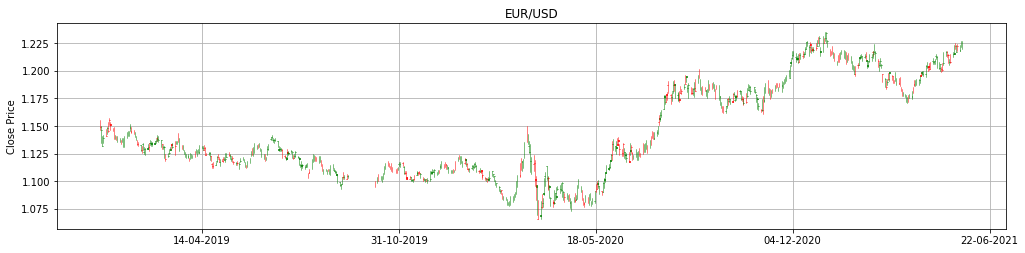

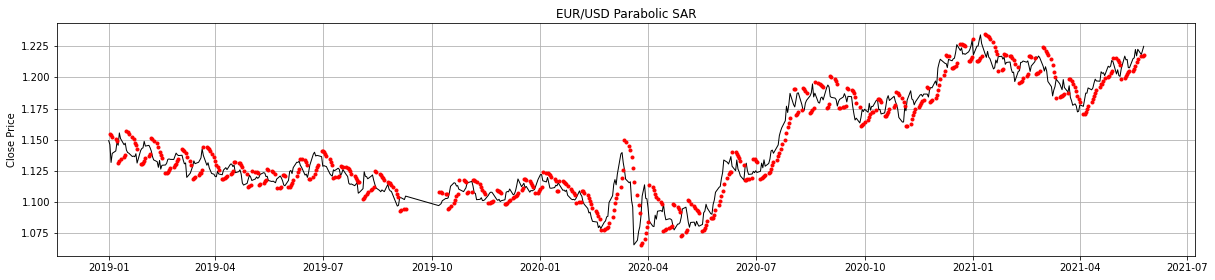

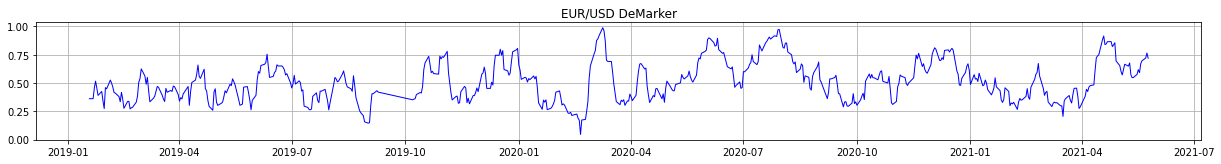

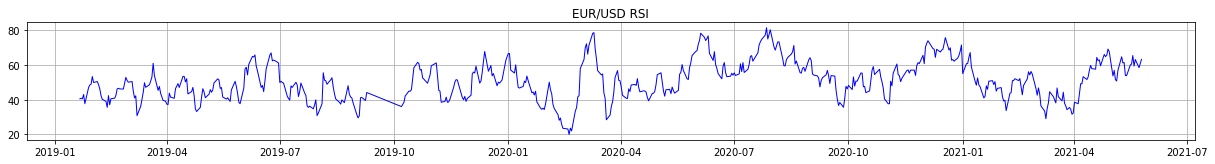

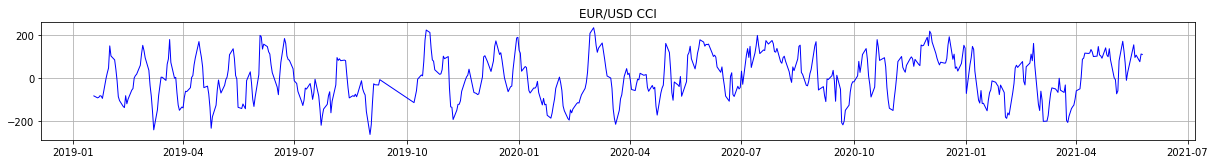

In [12]:
# Plot the price series chart
data['Date']= data.index
ohlc = data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

fig = plt.figure(figsize=(17,22))
ax = fig.add_subplot(5, 1, 1)
candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
#fig.autofmt_xdate()
plt.title('EUR/USD')
plt.ylabel('Close Price')
plt.grid(True)
#plt.tight_layout()
plt.show()

# Plot Parabolic SAR with close price
fig = plt.figure(figsize=(17,18))
ax = fig.add_subplot(5, 1, 2)
#ax.set_xticklabels([])
plt.plot(data['Close'],'k',lw=1)
plt.plot(data['SAR'],'.r')
plt.title('EUR/USD Parabolic SAR')
plt.ylabel('Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

#DEMARKER
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(5, 1, 3)
#ax.set_xticklabels([])
plt.plot(data['DeMarker'],'b',lw=1)
plt.title('EUR/USD DeMarker')
plt.grid(True)
plt.tight_layout()
plt.show()

#RSI 14 giorni
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(5, 1, 4)
plt.plot(data['RSI'],'b',lw=1)
plt.title('EUR/USD RSI')
plt.grid(True)
plt.tight_layout()
plt.show()

#CCI 14 giorni
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(5, 1, 3)
plt.plot(data['CCI'],'b',lw=1)
plt.title('EUR/USD CCI')
plt.grid(True)
plt.tight_layout()
plt.show()